In [ ]:
bimport numpy as np
import pandas as pd
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
from pytorch_pretrained_bert import BertForSequenceClassification, BertTokenizer, BertAdam
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
from google.colab import files
files.upload()

train_data = pd.read_csv('Corona_NLP_train.csv',encoding='latin_1')

Saving Corona_NLP_train.csv to Corona_NLP_train (1).csv


In [ ]:
from google.colab import files
files.upload()
test_data = pd.read_csv("tesst.csv",encoding='latin_1')

Saving tesst.csv to tesst (2).csv


In [ ]:
train_data.head(3)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive


In [ ]:
def data_analysis(df):

    output = pd.DataFrame(columns = ["Column", "Data Type", "#Unique values", "%NaN"])

    for column in df.columns:

        output = pd.concat([output, pd.DataFrame(np.array([column, df[column].dtypes, len(df[column].unique()), df[column].isna().sum() / df[column].shape[0]]).reshape(1, 4), columns = ["Column", "Data Type", "#Unique values", "%NaN"])])

    return output

In [ ]:
data_analysis(train_data)

,Column,Data Type,#Unique values,%NaN
0,UserName,int64,41157,0.0
0,ScreenName,int64,41157,0.0
0,Location,object,12221,0.208713
0,TweetAt,object,30,0.0
0,OriginalTweet,object,41157,0.0
0,Sentiment,object,5,0.0


<Axes: xlabel='Sentiment', ylabel='count'>

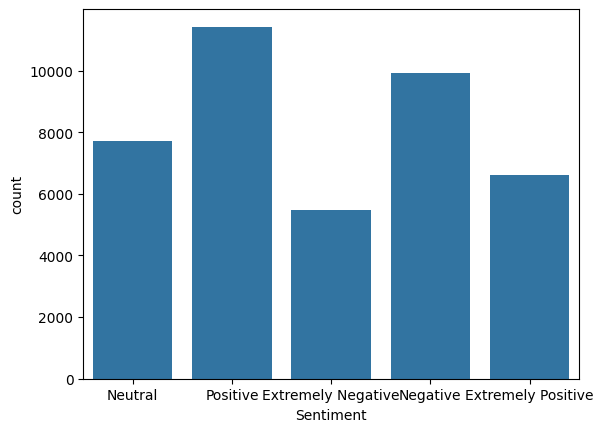

In [ ]:
sns.countplot(train_data, x = "Sentiment")

<Axes: xlabel='Sentiment', ylabel='count'>

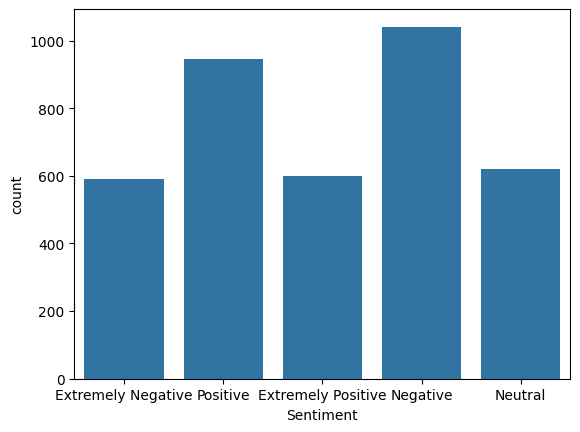

In [ ]:
sns.countplot(test_data, x="Sentiment")

In [ ]:
train_data['Sentiment'].value_counts(), test_data['Sentiment'].value_counts()

(Sentiment
 Positive              11422
 Negative               9917
 Neutral                7713
 Extremely Positive     6624
 Extremely Negative     5481
 Name: count, dtype: int64,
 Sentiment
 Negative              1041
 Positive               947
 Neutral                619
 Extremely Positive     599
 Extremely Negative     592
 Name: count, dtype: int64)

In [ ]:
train_df = train_data[['OriginalTweet', 'Sentiment']]
test_df = test_data[['OriginalTweet', 'Sentiment']]
pd.concat([data_analysis(train_df), data_analysis(test_df)])

,Column,Data Type,#Unique values,%NaN
0,OriginalTweet,object,41157,0.0
0,Sentiment,object,5,0.0
0,OriginalTweet,object,3798,0.0
0,Sentiment,object,5,0.0


In [ ]:
def sentiment_encoding(x):

    if x == "Neutral":
        return 0
    elif x == 'Positive':
        return 1
    elif x == 'Extremely Positive':
        return 1
    elif x == 'Negative':
        return 2
    elif x == 'Extremely Negative':
        return 2

In [ ]:
train_tweets = np.array([twit[0] for twit in train_df[['OriginalTweet']].values.tolist()])
test_tweets = np.array([twit[0] for twit in test_df[['OriginalTweet']].values.tolist()])

train_sentiment = np.array([sentiment_encoding(sentiment[0]) for sentiment in train_df[['Sentiment']].values.tolist()])
test_sentiment = np.array([sentiment_encoding(sentiment[0]) for sentiment in test_df[['Sentiment']].values.tolist()])

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
def preprocess_tweets(df):

    output = list()
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

    for sentence in tqdm(df):
        tags = r"@\w*"
        sentence = "[CLS] " + sentence + " [SEP]"

        sentence = [re.sub(tags, "", sentence)]
        text = []



        for word in sentence:
            #if word not in stop_words:
            text.append(word.lower())
        output.append(tokenizer.tokenize(" ".join(text)))
    return output

In [ ]:
train_tweets_processed = preprocess_tweets(train_tweets)
test_tweets_processed = preprocess_tweets(test_tweets)

100%|██████████| 3798/3798 [00:02<00:00, 1390.11it/s]


In [ ]:
max_length_train = max([len(twit) for twit in train_tweets_processed])
max_length_test = max([len(twit) for twit in test_tweets_processed])

max_length = max([max_length_train, max_length_test])

X_train_val = [tokenizer.convert_tokens_to_ids(twit) for twit in train_tweets_processed]
X_test = [tokenizer.convert_tokens_to_ids(twit) for twit in test_tweets_processed]

X_train_val = pad_sequences(X_train_val, maxlen=max_length, dtype="long", truncating="post", padding="post")
X_test = pad_sequences(X_test, maxlen=max_length, dtype="long", truncating="post", padding="post")

In [ ]:
attention_masks = []

for sent in tqdm(X_train_val):
    sent_mask = [float(i>0) for i in sent]
    attention_masks.append(sent_mask)

100%|██████████| 41157/41157 [00:05<00:00, 6899.49it/s]


In [ ]:
attention_masks_test = []

for sent in tqdm(X_test):
    sent_mask = [float(i>0) for i in sent]
    attention_masks_test.append(sent_mask)

100%|██████████| 3798/3798 [00:00<00:00, 9483.77it/s]


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, train_sentiment, test_size=0.15, shuffle=False)
attention_masks_train, attention_masks_val = train_test_split(attention_masks, test_size=0.15, shuffle=False)

In [ ]:
X_train = torch.tensor(X_train).to(device)
X_val = torch.tensor(X_val).to(device)
X_test = torch.tensor(X_test).to(device)

y_train = torch.tensor(y_train).to(device)
y_val= torch.tensor(y_val).to(device)
y_test = torch.tensor(test_sentiment).to(device)

attention_masks_train = torch.tensor(attention_masks_train).to(device)
attention_masks_val = torch.tensor(attention_masks_val).to(device)
attention_masks_test = torch.tensor(attention_masks_test).to(device)

In [ ]:
del train_data, test_data, train_df, test_df, train_sentiment, train_tweets, test_sentiment, test_tweets, train_tweets_processed, test_tweets_processed;

In [ ]:
batch_size = 8

train_data = TensorDataset(X_train, attention_masks_train, y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(X_val, attention_masks_val, y_val)
val_sampler = RandomSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

test_data = TensorDataset(X_test, attention_masks_test, y_test)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3).to(device)

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [{'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],'weight_decay_rate': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],'weight_decay_rate': 0.0}]

optimizer = BertAdam(optimizer_grouped_parameters, lr=2e-5, warmup=0.1)

/usr/local/lib/python3.10/dist-packages/pytorch_pretrained_bert/modeling.py:603: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_loca

In [ ]:
def pred_accuracy(preds, labels):

    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import torch
import numpy as np
from tqdm import tqdm

# Set the model to evaluation mode
model.eval()

# Initialize variables to accumulate accuracy and other metrics
numb_eval_steps = 0
eval_accuracy = 0

# Use lists instead of np.array for predictions and true_labels
predictions = []
true_labels = []

# Loop over batches in the dataloader
for batch in tqdm(test_dataloader, mininterval=30):

    # Unpack the batch directly (CPU environment)
    batch_X, batch_mask, batch_y = batch

    # No need for .to(device) since you're using CPU

    # Disable gradient computation for evaluation
    with torch.no_grad():
        # Forward pass through the model
        logits = model(batch_X, token_type_ids=None, attention_mask=batch_mask)

    # Move logits and labels to numpy arrays
    logits = logits.numpy()  # Directly convert to numpy for CPU
    y = batch_y.numpy()      # Convert labels to numpy

    # Calculate accuracy for this batch
    step_eval_accuracy = pred_accuracy(logits, y)
    eval_accuracy += step_eval_accuracy
    numb_eval_steps += 1

    # Accumulate predictions and true labels in lists
    predictions.extend(np.argmax(logits, axis=1))
    true_labels.extend(y)

# Convert lists to numpy arrays after loop
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Print final evaluation accuracy
print("Test Accuracy: {:.4f}".format(eval_accuracy / numb_eval_steps))

100%|██████████| 475/475 [1:05:50<00:00,  8.32s/it]

Test Accuracy: 0.4025


In [ ]:
matthews_corrcoef(true_labels, predictions)

-0.001448984637638592

In [ ]:
precision_recall_fscore_support(true_labels, predictions,  labels = [0, 1, 2])

(array([0.13157895, 0.40603567, 0.49350649]),
 array([0.01615509, 0.95730918, 0.02327006]),
 array([0.02877698, 0.57021768, 0.04444444]),
 array([ 619, 1546, 1633]))